In [1]:
import os
import sys
import numpy as np
import pandas as pd
from scipy import misc
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse import csgraph
from scipy import linalg
from pysheds.grid import Grid
from scipy import ndimage
from matplotlib import colors
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
from matplotlib.collections import LineCollection
import matplotlib.gridspec as gridspec

%matplotlib inline

In [2]:
sns.set_palette('husl', 2)

In [3]:
grid = Grid.from_raster('../../pysheds/data/n30w100_dir',
                 data_name='dir', input_type='ascii')

In [4]:
grid.read_raster('../../pysheds/data/n30w100_con',
                 data_name='dem', input_type='ascii')

In [5]:
dirmap = (64,  128,  1,   2,    4,   8,    16,  32)

# Specify pour point
x, y = -97.294167, 32.73750

# Delineate the catchment
grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name='catch',
               recursionlimit=15000, xytype='label')
# Clip the bounding box to the catchment
grid.clip_to('catch', precision=5)

grid.accumulation(data='catch', dirmap=dirmap, pad_inplace=False, out_name='acc')

In [6]:
profiles, connections = grid.extract_profiles('catch', grid.acc > 25)

In [7]:
geom = grid.extract_river_network('catch', grid.acc > 25)

# Lo Diffusion + advection

In [8]:
dx = 60. * (np.asarray([profile.size for profile in profiles]) + 1)
n = max(max(connections.keys()), max(connections.values())) + 1
s = np.ones(n)
I = np.eye(n)
u = 1.0*np.ones(n)
D = (u * dx / 10).mean()*np.ones(n)
dt = 1
I[0, 0] = 0

U = np.zeros((n, n))
W = np.zeros((n, n))

for i, j in connections.items():
    # Confirmed as i
    U[j, i] = u[i] * dt / dx[i]
    W[i, j] = u[i] * dt / dx[i]
    
V = np.diag(W @ s)

X = np.zeros((n, n))

for i, j in connections.items():
    X[i, j] = 2 / (dx[i] + dx[j])
    X[j, i] = 2 / (dx[i] + dx[j])
    
Y = np.diag(X @ s)

Z = np.diag(D * dt / dx)
S = (U - V) - Z @ (Y - X) + I

In [9]:
(u * dx / D).mean()

10.0

In [10]:
np.imag(np.linalg.eig(S)[0]).max(), np.imag(np.linalg.eig(S)[0]).min(), np.real(np.linalg.eig(S)[0]).max(), np.real(np.linalg.eig(S)[0]).min()

(0.0, 0.0, 0.9997196165216538, -0.0027755206889173286)

In [11]:
C = np.eye(n)

In [12]:
W_os = []
for i in range(len(S)):
    W_o_i = linalg.solve_discrete_lyapunov(S.T, I[[i]].T @ I[[i]])
    W_os.append(W_o_i)

In [13]:
Ws = []
ss = []
ns = 10

for i in range(ns):
    rs = np.asarray([np.linalg.matrix_rank(w + sum(Ws)) for w in W_os])
    ix = np.argmax(rs)
    ss.append(ix)
    Ws.append(W_os[ix])

In [14]:
W_c = linalg.solve_discrete_lyapunov(S, I)
st = np.argsort(np.diag(W_c))[::-1][:10]

In [15]:
np.random.seed(0)
x0 = np.ones(S.shape[0])

In [16]:
C = np.eye(S.shape[0])[ss]
Ac = np.eye(S.shape[0])
Wo_r = np.zeros(S.shape)
R_r = np.zeros(x0.shape)
ys_r = []

for i in range(3600):
    y = C @ Ac @ x0
    ys_r.append(y)
    Wo_r += (Ac.T @ C.T @ C @ Ac)
    R_r += (Ac.T @ C.T @ ys_r[i])
    Ac = S @ Ac

In [17]:
x0_hat_r = (np.linalg.pinv(Wo_r) @ R_r).ravel()
x0 = x0.ravel()

In [18]:
((x0_hat_r - x0.ravel())**2).sum() / len(x0)

0.005800646055611325

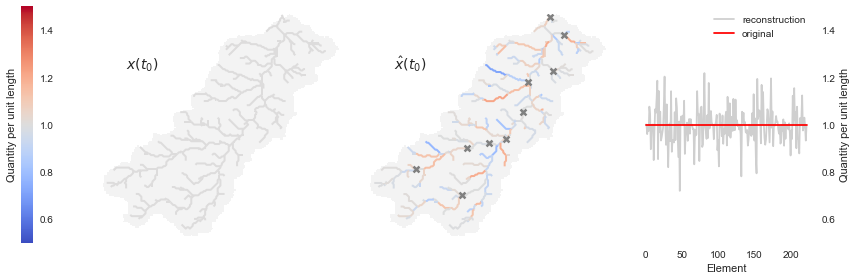

In [19]:
fig = plt.figure(figsize=(12,4))
spec = gridspec.GridSpec(ncols=5, nrows=1, figure=fig, width_ratios=[0.05, 0.025, 1, 1, 0.75])

ax = []
ax.append(fig.add_subplot(spec[0, 0]))
ax.append(fig.add_subplot(spec[0, 1]))
ax.append(fig.add_subplot(spec[0, 2]))
ax.append(fig.add_subplot(spec[0, 3]))
ax.append(fig.add_subplot(spec[0, 4]))

segs = [np.asarray(branch['geometry']['coordinates']) for branch in geom['features']]

for i in range(4):
    ax[i].set_facecolor('w')
    ax[i].xaxis.set_ticklabels([])
    ax[i].yaxis.set_ticklabels([])

ax[2].imshow(np.where(grid.view('catch'), 1, np.nan), zorder=1, cmap='Greys',
             vmin=0, vmax=6, extent=grid.extent, alpha=0.5)
mag = x0
norm = matplotlib.colors.Normalize(vmin=0.5, vmax=1.5)
mapper = cm.ScalarMappable(norm=norm, cmap='coolwarm')
colors = mapper.to_rgba(mag)
line_segments = LineCollection(segs, colors=colors, linewidths=2)
im = ax[2].add_collection(line_segments)
ax[2].autoscale()
ax[2].annotate('$x(t_0)$', (0.10, 0.75), xycoords='axes fraction', size=14)

ax[3].imshow(np.where(grid.view('catch'), 1, np.nan), zorder=1, cmap='Greys',
             vmin=0, vmax=6, extent=grid.extent, alpha=0.5)
mag = x0_hat_r
lmag = np.log10(mag + 1)
norm = matplotlib.colors.Normalize(vmin=0.5, vmax=1.5)
mapper = cm.ScalarMappable(norm=norm, cmap='coolwarm')
colors = mapper.to_rgba(mag)
line_segments = LineCollection(segs, colors=colors, linewidths=2)
im = ax[3].add_collection(line_segments)
ax[3].autoscale()
ax[3].annotate('$\hat{x}(t_0)$', (0.10, 0.75), xycoords='axes fraction', size=14)
coords = np.asarray([geom['features'][j]['geometry']['coordinates'][0]
                     for j in ss])
ax[3].scatter(coords[:,0], coords[:,1], zorder=2,
                   marker='x', c='0.5', s=35, edgecolor='0.1', linewidth=2.5)

cb1 = matplotlib.colorbar.ColorbarBase(ax[0], cmap='coolwarm',
                                norm=norm,
                                orientation='vertical', label='Quantity per unit length')
ax[0].yaxis.set_label_position('left')

ax[4].plot(x0_hat_r, c='0.75', alpha=0.75, label='reconstruction')
ax[4].plot(x0, c='r', label='original')
ax[4].yaxis.set_ticks_position('right')
ax[4].yaxis.set_label_position('right')
ax[4].set_facecolor('w')
ax[4].set_xlabel('Element')
ax[4].set_ylabel('Quantity per unit length')
ax[4].legend()
ax[4].set_ylim(0.5, 1.5)

plt.tight_layout()
#ax[1].scatter(coords[:,0], coords[:,1], zorder=2,
#                   marker='o', c='0.7', s=40, edgecolor='0.1', linewidth=1)

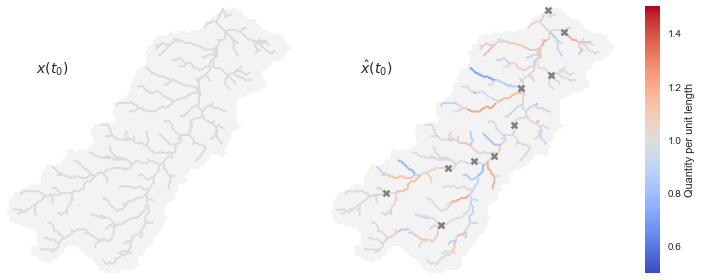

In [20]:
fig = plt.figure(figsize=(10,4))
spec = gridspec.GridSpec(ncols=3, nrows=1, figure=fig, width_ratios=[1, 1, 0.05])

ax = []
ax.append(fig.add_subplot(spec[0, 0]))
ax.append(fig.add_subplot(spec[0, 1]))
ax.append(fig.add_subplot(spec[0, 2]))

segs = [np.asarray(branch['geometry']['coordinates']) for branch in geom['features']]

for i in range(2):
    ax[i].set_facecolor('w')
    ax[i].xaxis.set_ticklabels([])
    ax[i].yaxis.set_ticklabels([])

ax[0].imshow(np.where(grid.view('catch'), 1, np.nan), zorder=1, cmap='Greys',
             vmin=0, vmax=6, extent=grid.extent, alpha=0.5)
mag = x0
norm = matplotlib.colors.Normalize(vmin=0.5, vmax=1.5)
mapper = cm.ScalarMappable(norm=norm, cmap='coolwarm')
colors = mapper.to_rgba(mag)
line_segments = LineCollection(segs, colors=colors, linewidths=2)
im = ax[0].add_collection(line_segments)
ax[0].autoscale()
ax[0].annotate('$x(t_0)$', (0.10, 0.75), xycoords='axes fraction', size=14)

ax[1].imshow(np.where(grid.view('catch'), 1, np.nan), zorder=1, cmap='Greys',
             vmin=0, vmax=6, extent=grid.extent, alpha=0.5)
mag = x0_hat_r
lmag = np.log10(mag + 1)
norm = matplotlib.colors.Normalize(vmin=0.5, vmax=1.5)
mapper = cm.ScalarMappable(norm=norm, cmap='coolwarm')
colors = mapper.to_rgba(mag)
line_segments = LineCollection(segs, colors=colors, linewidths=2)
im = ax[1].add_collection(line_segments)
ax[1].autoscale()
ax[1].annotate('$\hat{x}(t_0)$', (0.10, 0.75), xycoords='axes fraction', size=14)
coords = np.asarray([geom['features'][j]['geometry']['coordinates'][0]
                     for j in ss])
ax[1].scatter(coords[:,0], coords[:,1], zorder=2,
                   marker='x', c='0.5', s=35, edgecolor='0.1', linewidth=2.5)

cb1 = matplotlib.colorbar.ColorbarBase(ax[2], cmap='coolwarm',
                                norm=norm,
                                orientation='vertical', label='Quantity per unit length')

plt.tight_layout()
plt.subplots_adjust(wspace=0.1)
#ax[1].scatter(coords[:,0], coords[:,1], zorder=2,
#                   marker='o', c='0.7', s=40, edgecolor='0.1', linewidth=1)

In [21]:
Adj = np.zeros((n, n))

for i, j in connections.items():
    # Confirmed as i
    Adj[j, i] = 1
    Adj[i, j] = 1
    
Lap = sparse.csgraph.laplacian(Adj)

In [22]:
L, U = np.linalg.eigh(Lap)
ghat = np.exp(-1*L)

In [23]:
x0 = U[:,0]
x0 = - x0
#x0 = x0 - x0.min()
#x0 = x0 / x0.max()

In [24]:
C = np.eye(S.shape[0])[ss]
Ac = np.eye(S.shape[0])
Wo_r = np.zeros(S.shape)
R_r = np.zeros(x0.shape)
ys_r = []

for i in range(3600):
    y = C @ Ac @ x0
    ys_r.append(y)
    Wo_r += (Ac.T @ C.T @ C @ Ac)
    R_r += (Ac.T @ C.T @ ys_r[i])
    Ac = S @ Ac

In [25]:
x0_hat_r = (np.linalg.pinv(Wo_r) @ R_r).ravel()
x0 = x0.ravel()

In [26]:
((x0_hat_r - x0.ravel())**2).sum() / len(x0)

5.477506840198302e-05

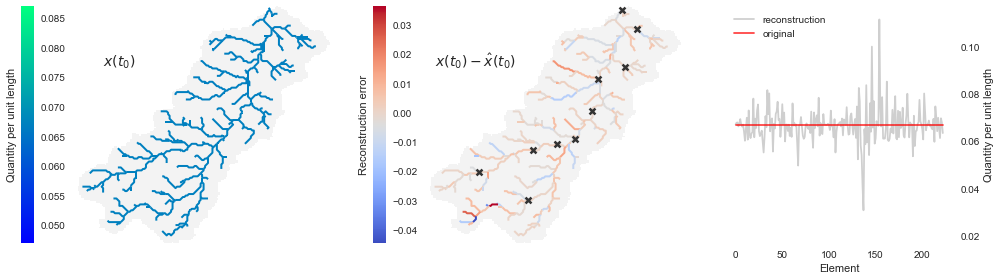

In [27]:
fig = plt.figure(figsize=(14,4))
spec = gridspec.GridSpec(ncols=5, nrows=1, figure=fig, width_ratios=[0.05, 1, 0.05, 1, 0.9])

ax = []
ax.append(fig.add_subplot(spec[0, 0]))
ax.append(fig.add_subplot(spec[0, 1]))
ax.append(fig.add_subplot(spec[0, 2]))
ax.append(fig.add_subplot(spec[0, 3]))
ax.append(fig.add_subplot(spec[0, 4]))

segs = [np.asarray(branch['geometry']['coordinates']) for branch in geom['features']]

for i in range(4):
    ax[i].set_facecolor('w')
    ax[i].xaxis.set_ticklabels([])
    ax[i].yaxis.set_ticklabels([])

ax[1].imshow(np.where(grid.view('catch'), 1, np.nan), zorder=1, cmap='Greys',
             vmin=0, vmax=6, extent=grid.extent, alpha=0.5)
mag = x0
norm = matplotlib.colors.Normalize(vmin=x0.min() - 0.02, vmax=x0.max() + 0.02)
mapper = cm.ScalarMappable(norm=norm, cmap='winter_r')
colors = mapper.to_rgba(mag)
line_segments = LineCollection(segs, colors=colors, linewidths=2)
im = ax[1].add_collection(line_segments)
ax[1].autoscale()
ax[1].annotate('$x(t_0)$', (0.10, 0.75), xycoords='axes fraction', size=14)

ax[3].imshow(np.where(grid.view('catch'), 1, np.nan), zorder=1, cmap='Greys',
             vmin=0, vmax=6, extent=grid.extent, alpha=0.5)
mag = x0 - x0_hat_r
lmag = np.log10(mag + 1)
err_norm = matplotlib.colors.Normalize(vmin=mag.min(), vmax=mag.max())
mapper = cm.ScalarMappable(norm=err_norm, cmap='coolwarm')
colors = mapper.to_rgba(mag)
line_segments = LineCollection(segs, colors=colors, linewidths=2)
im = ax[3].add_collection(line_segments)
ax[3].autoscale()
ax[3].annotate('$x(t_0) - \hat{x}(t_0)$', (0.02, 0.75), xycoords='axes fraction', size=14)
coords = np.asarray([geom['features'][j]['geometry']['coordinates'][0]
                     for j in ss])
ax[3].scatter(coords[:,0], coords[:,1], zorder=2,
                   marker='x', c='0.2', s=35, edgecolor='0.1', linewidth=2.5)

cb1 = matplotlib.colorbar.ColorbarBase(ax[0], cmap='winter',
                                norm=norm,
                                orientation='vertical', label='Quantity per unit length')
ax[0].yaxis.set_label_position('left')

cb1 = matplotlib.colorbar.ColorbarBase(ax[2], cmap='coolwarm',
                                norm=err_norm,
                                orientation='vertical', label='Reconstruction error')
ax[2].yaxis.set_label_position('left')

ax[4].plot(x0_hat_r[np.argsort(x0)[::-1]], c='0.75', alpha=0.75, label='reconstruction')
ax[4].plot(x0[np.argsort(x0)[::-1]], c='r', alpha=0.75, label='original')
ax[4].yaxis.set_ticks_position('right')
ax[4].yaxis.set_label_position('right')
ax[4].set_facecolor('w')
ax[4].set_xlabel('Element')
ax[4].set_ylabel('Quantity per unit length')
ax[4].legend()
ax[4].set_ylim(x0.min() - 0.05, x0.max() + 0.05)

plt.tight_layout()
#ax[1].scatter(coords[:,0], coords[:,1], zorder=2,
#                   marker='o', c='0.7', s=40, edgecolor='0.1', linewidth=1)

In [28]:
x0 = U[:,1]
#x0 = x0 - x0.min()
#x0 = x0 / x0.max()

In [29]:
C = np.eye(S.shape[0])[ss]
Ac = np.eye(S.shape[0])
Wo_r = np.zeros(S.shape)
R_r = np.zeros(x0.shape)
ys_r = []

for i in range(3600):
    y = C @ Ac @ x0
    ys_r.append(y)
    Wo_r += (Ac.T @ C.T @ C @ Ac)
    R_r += (Ac.T @ C.T @ ys_r[i])
    Ac = S @ Ac

In [30]:
x0_hat_r = (np.linalg.pinv(Wo_r) @ R_r).ravel()
x0 = x0.ravel()

In [31]:
((x0_hat_r - x0.ravel())**2).sum() / len(x0)

4.293294547300726e-05

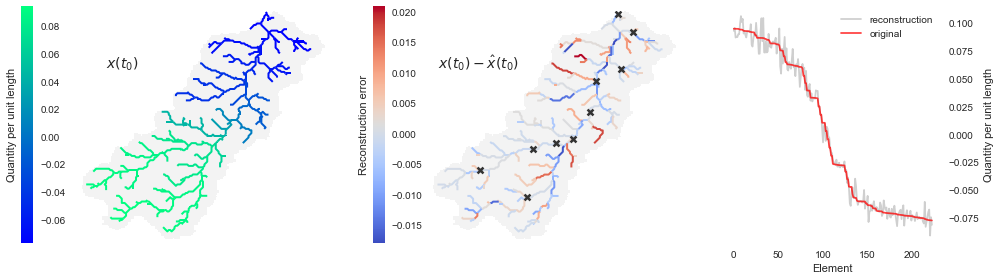

In [32]:
fig = plt.figure(figsize=(14,4))
spec = gridspec.GridSpec(ncols=5, nrows=1, figure=fig, width_ratios=[0.05, 1, 0.05, 1, 0.9])

ax = []
ax.append(fig.add_subplot(spec[0, 0]))
ax.append(fig.add_subplot(spec[0, 1]))
ax.append(fig.add_subplot(spec[0, 2]))
ax.append(fig.add_subplot(spec[0, 3]))
ax.append(fig.add_subplot(spec[0, 4]))

segs = [np.asarray(branch['geometry']['coordinates']) for branch in geom['features']]

for i in range(4):
    ax[i].set_facecolor('w')
    ax[i].xaxis.set_ticklabels([])
    ax[i].yaxis.set_ticklabels([])

ax[1].imshow(np.where(grid.view('catch'), 1, np.nan), zorder=1, cmap='Greys',
             vmin=0, vmax=6, extent=grid.extent, alpha=0.5)
mag = x0
norm = matplotlib.colors.Normalize(vmin=x0.min(), vmax=x0.max())
mapper = cm.ScalarMappable(norm=norm, cmap='winter_r')
colors = mapper.to_rgba(mag)
line_segments = LineCollection(segs, colors=colors, linewidths=2)
im = ax[1].add_collection(line_segments)
ax[1].autoscale()
ax[1].annotate('$x(t_0)$', (0.10, 0.75), xycoords='axes fraction', size=14)

ax[3].imshow(np.where(grid.view('catch'), 1, np.nan), zorder=1, cmap='Greys',
             vmin=0, vmax=6, extent=grid.extent, alpha=0.5)
mag = x0 - x0_hat_r
lmag = np.log10(mag + 1)
err_norm = matplotlib.colors.Normalize(vmin=mag.min(), vmax=mag.max())
mapper = cm.ScalarMappable(norm=err_norm, cmap='coolwarm')
colors = mapper.to_rgba(mag)
line_segments = LineCollection(segs, colors=colors, linewidths=2)
im = ax[3].add_collection(line_segments)
ax[3].autoscale()
ax[3].annotate('$x(t_0) - \hat{x}(t_0)$', (0.02, 0.75), xycoords='axes fraction', size=14)
coords = np.asarray([geom['features'][j]['geometry']['coordinates'][0]
                     for j in ss])
ax[3].scatter(coords[:,0], coords[:,1], zorder=2,
                   marker='x', c='0.2', s=35, edgecolor='0.1', linewidth=2.5)

cb1 = matplotlib.colorbar.ColorbarBase(ax[0], cmap='winter',
                                norm=norm,
                                orientation='vertical', label='Quantity per unit length')
ax[0].yaxis.set_label_position('left')

cb1 = matplotlib.colorbar.ColorbarBase(ax[2], cmap='coolwarm',
                                norm=err_norm,
                                orientation='vertical', label='Reconstruction error')
ax[2].yaxis.set_label_position('left')

ax[4].plot(x0_hat_r[np.argsort(x0)[::-1]], c='0.75', alpha=0.75, label='reconstruction')
ax[4].plot(x0[np.argsort(x0)[::-1]], c='r', alpha=0.75, label='original')
ax[4].yaxis.set_ticks_position('right')
ax[4].yaxis.set_label_position('right')
ax[4].set_facecolor('w')
ax[4].set_xlabel('Element')
ax[4].set_ylabel('Quantity per unit length')
ax[4].legend()
ax[4].set_ylim(x0.min() - 0.02, x0.max() + 0.02)

plt.tight_layout()
#ax[1].scatter(coords[:,0], coords[:,1], zorder=2,
#                   marker='o', c='0.7', s=40, edgecolor='0.1', linewidth=1)

In [33]:
x0 = U[:,2]
#x0 = x0 - x0.min()
#x0 = x0 / x0.max()

In [34]:
C = np.eye(S.shape[0])[ss]
Ac = np.eye(S.shape[0])
Wo_r = np.zeros(S.shape)
R_r = np.zeros(x0.shape)
ys_r = []

for i in range(3600):
    y = C @ Ac @ x0
    ys_r.append(y)
    Wo_r += (Ac.T @ C.T @ C @ Ac)
    R_r += (Ac.T @ C.T @ ys_r[i])
    Ac = S @ Ac

In [35]:
x0_hat_r = (np.linalg.pinv(Wo_r) @ R_r).ravel()
x0 = x0.ravel()

In [36]:
((x0_hat_r - x0.ravel())**2).sum() / len(x0)

8.301716252730643e-05

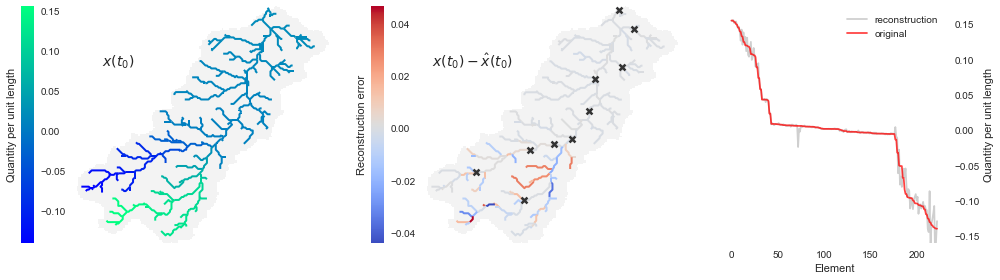

In [37]:
fig = plt.figure(figsize=(14,4))
spec = gridspec.GridSpec(ncols=5, nrows=1, figure=fig, width_ratios=[0.05, 1, 0.05, 1, 0.9])

ax = []
ax.append(fig.add_subplot(spec[0, 0]))
ax.append(fig.add_subplot(spec[0, 1]))
ax.append(fig.add_subplot(spec[0, 2]))
ax.append(fig.add_subplot(spec[0, 3]))
ax.append(fig.add_subplot(spec[0, 4]))

segs = [np.asarray(branch['geometry']['coordinates']) for branch in geom['features']]

for i in range(4):
    ax[i].set_facecolor('w')
    ax[i].xaxis.set_ticklabels([])
    ax[i].yaxis.set_ticklabels([])

ax[1].imshow(np.where(grid.view('catch'), 1, np.nan), zorder=1, cmap='Greys',
             vmin=0, vmax=6, extent=grid.extent, alpha=0.5)
mag = x0
norm = matplotlib.colors.Normalize(vmin=x0.min(), vmax=x0.max())
mapper = cm.ScalarMappable(norm=norm, cmap='winter_r')
colors = mapper.to_rgba(mag)
line_segments = LineCollection(segs, colors=colors, linewidths=2)
im = ax[1].add_collection(line_segments)
ax[1].autoscale()
ax[1].annotate('$x(t_0)$', (0.10, 0.75), xycoords='axes fraction', size=14)

ax[3].imshow(np.where(grid.view('catch'), 1, np.nan), zorder=1, cmap='Greys',
             vmin=0, vmax=6, extent=grid.extent, alpha=0.5)
mag = x0 - x0_hat_r
lmag = np.log10(mag + 1)
err_norm = matplotlib.colors.Normalize(vmin=mag.min(), vmax=mag.max())
mapper = cm.ScalarMappable(norm=err_norm, cmap='coolwarm')
colors = mapper.to_rgba(mag)
line_segments = LineCollection(segs, colors=colors, linewidths=2)
im = ax[3].add_collection(line_segments)
ax[3].autoscale()
ax[3].annotate('$x(t_0) - \hat{x}(t_0)$', (0.02, 0.75), xycoords='axes fraction', size=14)
coords = np.asarray([geom['features'][j]['geometry']['coordinates'][0]
                     for j in ss])
ax[3].scatter(coords[:,0], coords[:,1], zorder=2,
                   marker='x', c='0.2', s=35, edgecolor='0.1', linewidth=2.5)

cb1 = matplotlib.colorbar.ColorbarBase(ax[0], cmap='winter',
                                norm=norm,
                                orientation='vertical', label='Quantity per unit length')
ax[0].yaxis.set_label_position('left')

cb1 = matplotlib.colorbar.ColorbarBase(ax[2], cmap='coolwarm',
                                norm=err_norm,
                                orientation='vertical', label='Reconstruction error')
ax[2].yaxis.set_label_position('left')

ax[4].plot(x0_hat_r[np.argsort(x0)[::-1]], c='0.75', alpha=0.75, label='reconstruction')
ax[4].plot(x0[np.argsort(x0)[::-1]], c='r', alpha=0.75, label='original')
ax[4].yaxis.set_ticks_position('right')
ax[4].yaxis.set_label_position('right')
ax[4].set_facecolor('w')
ax[4].set_xlabel('Element')
ax[4].set_ylabel('Quantity per unit length')
ax[4].legend()
ax[4].set_ylim(x0.min() - 0.02, x0.max() + 0.02)

plt.tight_layout()
#ax[1].scatter(coords[:,0], coords[:,1], zorder=2,
#                   marker='o', c='0.7', s=40, edgecolor='0.1', linewidth=1)

In [38]:
x0 = U[:,3]
#x0 = x0 - x0.min()
#x0 = x0 / x0.max()

In [39]:
C = np.eye(S.shape[0])[ss]
Ac = np.eye(S.shape[0])
Wo_r = np.zeros(S.shape)
R_r = np.zeros(x0.shape)
ys_r = []

for i in range(3600):
    y = C @ Ac @ x0
    ys_r.append(y)
    Wo_r += (Ac.T @ C.T @ C @ Ac)
    R_r += (Ac.T @ C.T @ ys_r[i])
    Ac = S @ Ac

In [40]:
x0_hat_r = (np.linalg.pinv(Wo_r) @ R_r).ravel()
x0 = x0.ravel()

In [41]:
((x0_hat_r - x0.ravel())**2).sum() / len(x0)

9.076704628747969e-05

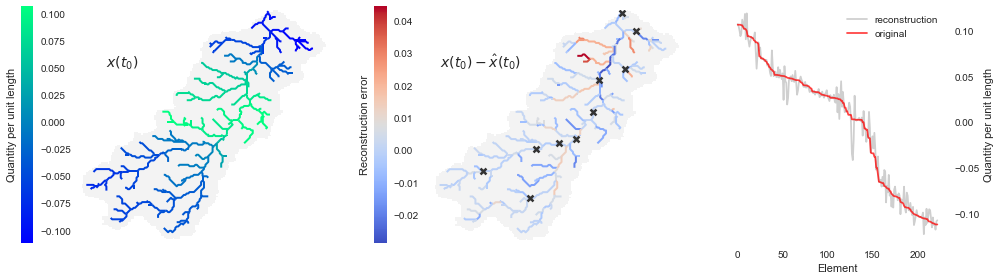

In [42]:
fig = plt.figure(figsize=(14,4))
spec = gridspec.GridSpec(ncols=5, nrows=1, figure=fig, width_ratios=[0.05, 1, 0.05, 1, 0.9])

ax = []
ax.append(fig.add_subplot(spec[0, 0]))
ax.append(fig.add_subplot(spec[0, 1]))
ax.append(fig.add_subplot(spec[0, 2]))
ax.append(fig.add_subplot(spec[0, 3]))
ax.append(fig.add_subplot(spec[0, 4]))

segs = [np.asarray(branch['geometry']['coordinates']) for branch in geom['features']]

for i in range(4):
    ax[i].set_facecolor('w')
    ax[i].xaxis.set_ticklabels([])
    ax[i].yaxis.set_ticklabels([])

ax[1].imshow(np.where(grid.view('catch'), 1, np.nan), zorder=1, cmap='Greys',
             vmin=0, vmax=6, extent=grid.extent, alpha=0.5)
mag = x0
norm = matplotlib.colors.Normalize(vmin=x0.min(), vmax=x0.max())
mapper = cm.ScalarMappable(norm=norm, cmap='winter_r')
colors = mapper.to_rgba(mag)
line_segments = LineCollection(segs, colors=colors, linewidths=2)
im = ax[1].add_collection(line_segments)
ax[1].autoscale()
ax[1].annotate('$x(t_0)$', (0.10, 0.75), xycoords='axes fraction', size=14)

ax[3].imshow(np.where(grid.view('catch'), 1, np.nan), zorder=1, cmap='Greys',
             vmin=0, vmax=6, extent=grid.extent, alpha=0.5)
mag = x0 - x0_hat_r
lmag = np.log10(mag + 1)
err_norm = matplotlib.colors.Normalize(vmin=mag.min(), vmax=mag.max())
mapper = cm.ScalarMappable(norm=err_norm, cmap='coolwarm')
colors = mapper.to_rgba(mag)
line_segments = LineCollection(segs, colors=colors, linewidths=2)
im = ax[3].add_collection(line_segments)
ax[3].autoscale()
ax[3].annotate('$x(t_0) - \hat{x}(t_0)$', (0.02, 0.75), xycoords='axes fraction', size=14)
coords = np.asarray([geom['features'][j]['geometry']['coordinates'][0]
                     for j in ss])
ax[3].scatter(coords[:,0], coords[:,1], zorder=2,
                   marker='x', c='0.2', s=35, edgecolor='0.1', linewidth=2.5)

cb1 = matplotlib.colorbar.ColorbarBase(ax[0], cmap='winter',
                                norm=norm,
                                orientation='vertical', label='Quantity per unit length')
ax[0].yaxis.set_label_position('left')

cb1 = matplotlib.colorbar.ColorbarBase(ax[2], cmap='coolwarm',
                                norm=err_norm,
                                orientation='vertical', label='Reconstruction error')
ax[2].yaxis.set_label_position('left')

ax[4].plot(x0_hat_r[np.argsort(x0)[::-1]], c='0.75', alpha=0.75, label='reconstruction')
ax[4].plot(x0[np.argsort(x0)[::-1]], c='r', alpha=0.75, label='original')
ax[4].yaxis.set_ticks_position('right')
ax[4].yaxis.set_label_position('right')
ax[4].set_facecolor('w')
ax[4].set_xlabel('Element')
ax[4].set_ylabel('Quantity per unit length')
ax[4].legend()
ax[4].set_ylim(x0.min() - 0.02, x0.max() + 0.02)

plt.tight_layout()
#ax[1].scatter(coords[:,0], coords[:,1], zorder=2,
#                   marker='o', c='0.7', s=40, edgecolor='0.1', linewidth=1)

In [43]:
x0 = U[:,4]
#x0 = x0 - x0.min()
#x0 = x0 / x0.max()

In [44]:
C = np.eye(S.shape[0])[ss]
Ac = np.eye(S.shape[0])
Wo_r = np.zeros(S.shape)
R_r = np.zeros(x0.shape)
ys_r = []

for i in range(3600):
    y = C @ Ac @ x0
    ys_r.append(y)
    Wo_r += (Ac.T @ C.T @ C @ Ac)
    R_r += (Ac.T @ C.T @ ys_r[i])
    Ac = S @ Ac

In [45]:
x0_hat_r = (np.linalg.pinv(Wo_r) @ R_r).ravel()
x0 = x0.ravel()

In [46]:
((x0_hat_r - x0.ravel())**2).sum() / len(x0)

9.196984794946782e-05

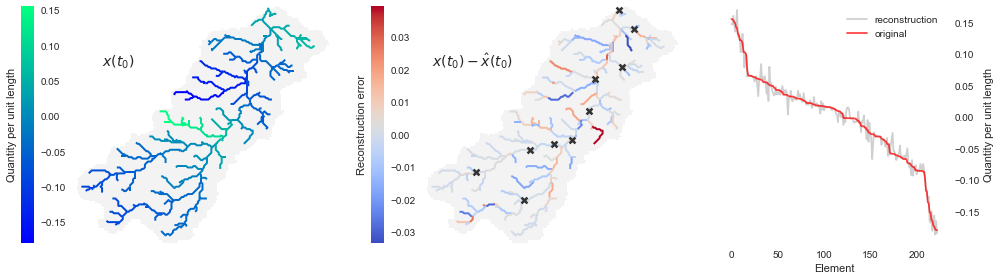

In [47]:
fig = plt.figure(figsize=(14,4))
spec = gridspec.GridSpec(ncols=5, nrows=1, figure=fig, width_ratios=[0.05, 1, 0.05, 1, 0.9])

ax = []
ax.append(fig.add_subplot(spec[0, 0]))
ax.append(fig.add_subplot(spec[0, 1]))
ax.append(fig.add_subplot(spec[0, 2]))
ax.append(fig.add_subplot(spec[0, 3]))
ax.append(fig.add_subplot(spec[0, 4]))

segs = [np.asarray(branch['geometry']['coordinates']) for branch in geom['features']]

for i in range(4):
    ax[i].set_facecolor('w')
    ax[i].xaxis.set_ticklabels([])
    ax[i].yaxis.set_ticklabels([])

ax[1].imshow(np.where(grid.view('catch'), 1, np.nan), zorder=1, cmap='Greys',
             vmin=0, vmax=6, extent=grid.extent, alpha=0.5)
mag = x0
norm = matplotlib.colors.Normalize(vmin=x0.min(), vmax=x0.max())
mapper = cm.ScalarMappable(norm=norm, cmap='winter_r')
colors = mapper.to_rgba(mag)
line_segments = LineCollection(segs, colors=colors, linewidths=2)
im = ax[1].add_collection(line_segments)
ax[1].autoscale()
ax[1].annotate('$x(t_0)$', (0.10, 0.75), xycoords='axes fraction', size=14)

ax[3].imshow(np.where(grid.view('catch'), 1, np.nan), zorder=1, cmap='Greys',
             vmin=0, vmax=6, extent=grid.extent, alpha=0.5)
mag = x0 - x0_hat_r
lmag = np.log10(mag + 1)
err_norm = matplotlib.colors.Normalize(vmin=mag.min(), vmax=mag.max())
mapper = cm.ScalarMappable(norm=err_norm, cmap='coolwarm')
colors = mapper.to_rgba(mag)
line_segments = LineCollection(segs, colors=colors, linewidths=2)
im = ax[3].add_collection(line_segments)
ax[3].autoscale()
ax[3].annotate('$x(t_0) - \hat{x}(t_0)$', (0.02, 0.75), xycoords='axes fraction', size=14)
coords = np.asarray([geom['features'][j]['geometry']['coordinates'][0]
                     for j in ss])
ax[3].scatter(coords[:,0], coords[:,1], zorder=2,
                   marker='x', c='0.2', s=35, edgecolor='0.1', linewidth=2.5)

cb1 = matplotlib.colorbar.ColorbarBase(ax[0], cmap='winter',
                                norm=norm,
                                orientation='vertical', label='Quantity per unit length')
ax[0].yaxis.set_label_position('left')

cb1 = matplotlib.colorbar.ColorbarBase(ax[2], cmap='coolwarm',
                                norm=err_norm,
                                orientation='vertical', label='Reconstruction error')
ax[2].yaxis.set_label_position('left')

ax[4].plot(x0_hat_r[np.argsort(x0)[::-1]], c='0.75', alpha=0.75, label='reconstruction')
ax[4].plot(x0[np.argsort(x0)[::-1]], c='r', alpha=0.75, label='original')
ax[4].yaxis.set_ticks_position('right')
ax[4].yaxis.set_label_position('right')
ax[4].set_facecolor('w')
ax[4].set_xlabel('Element')
ax[4].set_ylabel('Quantity per unit length')
ax[4].legend()
ax[4].set_ylim(x0.min() - 0.02, x0.max() + 0.02)

plt.tight_layout()
#ax[1].scatter(coords[:,0], coords[:,1], zorder=2,
#                   marker='o', c='0.7', s=40, edgecolor='0.1', linewidth=1)

In [48]:
x0 = U[:,5]
#x0 = x0 - x0.min()
#x0 = x0 / x0.max()

In [49]:
C = np.eye(S.shape[0])[ss]
Ac = np.eye(S.shape[0])
Wo_r = np.zeros(S.shape)
R_r = np.zeros(x0.shape)
ys_r = []

for i in range(3600):
    y = C @ Ac @ x0
    ys_r.append(y)
    Wo_r += (Ac.T @ C.T @ C @ Ac)
    R_r += (Ac.T @ C.T @ ys_r[i])
    Ac = S @ Ac

In [50]:
x0_hat_r = (np.linalg.pinv(Wo_r) @ R_r).ravel()
x0 = x0.ravel()

In [51]:
((x0_hat_r - x0.ravel())**2).sum() / len(x0)

0.00016778949607146538

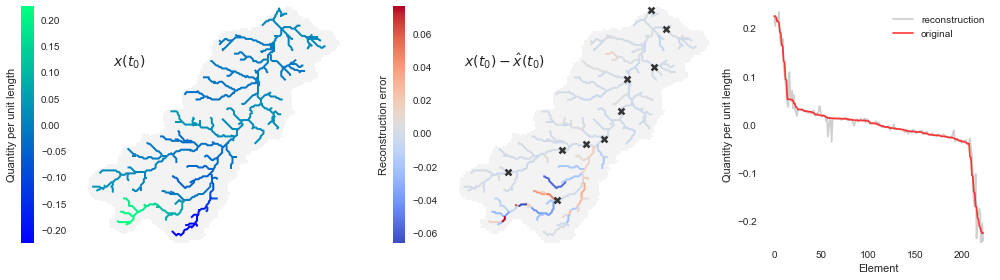

In [52]:
fig = plt.figure(figsize=(14,4))
spec = gridspec.GridSpec(ncols=5, nrows=1, figure=fig, width_ratios=[0.05, 1, 0.05, 1, 0.9])

ax = []
ax.append(fig.add_subplot(spec[0, 0]))
ax.append(fig.add_subplot(spec[0, 1]))
ax.append(fig.add_subplot(spec[0, 2]))
ax.append(fig.add_subplot(spec[0, 3]))
ax.append(fig.add_subplot(spec[0, 4]))

segs = [np.asarray(branch['geometry']['coordinates']) for branch in geom['features']]

for i in range(4):
    ax[i].set_facecolor('w')
    ax[i].xaxis.set_ticklabels([])
    ax[i].yaxis.set_ticklabels([])

ax[1].imshow(np.where(grid.view('catch'), 1, np.nan), zorder=1, cmap='Greys',
             vmin=0, vmax=6, extent=grid.extent, alpha=0.5)
mag = x0
norm = matplotlib.colors.Normalize(vmin=x0.min(), vmax=x0.max())
mapper = cm.ScalarMappable(norm=norm, cmap='winter_r')
colors = mapper.to_rgba(mag)
line_segments = LineCollection(segs, colors=colors, linewidths=2)
im = ax[1].add_collection(line_segments)
ax[1].autoscale()
ax[1].annotate('$x(t_0)$', (0.10, 0.75), xycoords='axes fraction', size=14)

ax[3].imshow(np.where(grid.view('catch'), 1, np.nan), zorder=1, cmap='Greys',
             vmin=0, vmax=6, extent=grid.extent, alpha=0.5)
mag = x0 - x0_hat_r
lmag = np.log10(mag + 1)
err_norm = matplotlib.colors.Normalize(vmin=mag.min(), vmax=mag.max())
mapper = cm.ScalarMappable(norm=err_norm, cmap='coolwarm')
colors = mapper.to_rgba(mag)
line_segments = LineCollection(segs, colors=colors, linewidths=2)
im = ax[3].add_collection(line_segments)
ax[3].autoscale()
ax[3].annotate('$x(t_0) - \hat{x}(t_0)$', (0.02, 0.75), xycoords='axes fraction', size=14)
coords = np.asarray([geom['features'][j]['geometry']['coordinates'][0]
                     for j in ss])
ax[3].scatter(coords[:,0], coords[:,1], zorder=2,
                   marker='x', c='0.2', s=35, edgecolor='0.1', linewidth=2.5)

cb1 = matplotlib.colorbar.ColorbarBase(ax[0], cmap='winter',
                                norm=norm,
                                orientation='vertical', label='Quantity per unit length')
ax[0].yaxis.set_label_position('left')

cb1 = matplotlib.colorbar.ColorbarBase(ax[2], cmap='coolwarm',
                                norm=err_norm,
                                orientation='vertical', label='Reconstruction error')
ax[2].yaxis.set_label_position('left')

ax[4].plot(x0_hat_r[np.argsort(x0)[::-1]], c='0.75', alpha=0.75, label='reconstruction')
ax[4].plot(x0[np.argsort(x0)[::-1]], c='r', alpha=0.75, label='original')
#ax[4].yaxis.set_ticks_position('right')
#ax[4].yaxis.set_label_position('right')
ax[4].set_facecolor('w')
ax[4].set_xlabel('Element')
ax[4].set_ylabel('Quantity per unit length')
ax[4].legend()
ax[4].set_ylim(x0.min() - 0.02, x0.max() + 0.02)

plt.tight_layout()
#ax[1].scatter(coords[:,0], coords[:,1], zorder=2,
#                   marker='o', c='0.7', s=40, edgecolor='0.1', linewidth=1)